# Задание 1.1
Используйте набор данных с изображениями рукописных цифр (например, MNIST) и обучите модель классификации (например, метод опорных векторов) для распознавания цифр.

## 0. Импорты библиотек и загрузка данных

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [94]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report, accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import numpy as np
import pandas as pd 

import random
from joblib import dump, load

In [3]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [4]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data.values, mnist.target.values
X.shape, y.shape

((70000, 784), (70000,))

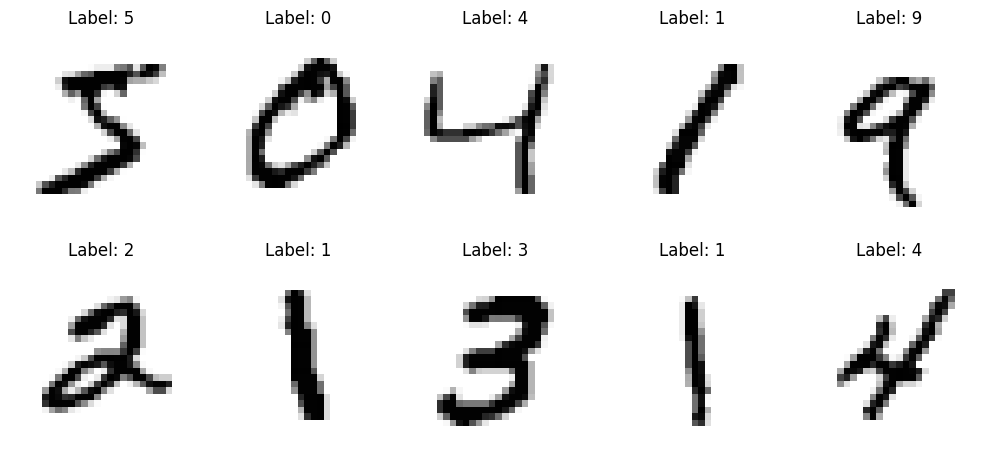

In [5]:
X_reshaped = X.reshape(-1, 28, 28)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(X_reshaped[i], cmap='binary')
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
unique_labels, counts = np.unique(y, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 6903
Label 1: 7877
Label 2: 6990
Label 3: 7141
Label 4: 6824
Label 5: 6313
Label 6: 6876
Label 7: 7293
Label 8: 6825
Label 9: 6958


In [7]:
X = X / 255.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. Обучение моделей и их точность

In [9]:
def print_cross_val_scores(model_name: str, scores: np.ndarray):
    print(f"\033[1m{model_name}\033[0m")
    scores_str = ', '.join([f"{score:.4f}" for score in scores])
    print(f"Cross-validation scores: \033[90m[{scores_str}]\033[0m")
    print(f"Mean cross-validation score: \033[38;5;208m{scores.mean():.4f}\033[0m")
    print(f"Best cross-validation score: \033[92m{scores.max():.4f}\033[0m\n")

In [10]:
def print_grid_search_results(grid_search: GridSearchCV, model_name:str="Grid Search Results"):
    print(f"\033[1m{model_name}\033[0m")
    print(f"Best parameters: \033[92m{grid_search.best_params_}\033[0m")
    print(f"Best cross-validation score: \033[92m{grid_search.best_score_:.4f}\033[0m\n")

In [ ]:
def print_class_f1(y_true, y_pred, sort=False, return_df=False):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    classes = np.unique(np.concatenate([y_true, y_pred]))
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=classes, zero_division=0
    )

    df = pd.DataFrame({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support.astype(int)
    }, index=classes)

    if sort:
        df = df.sort_values('f1')

    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Macro F1: {macro_f1:.4f}   |   Weighted F1: {weighted_f1:.4f}\n")

    print("Classification report (per-class):")
    print(classification_report(y_true, y_pred, labels=classes, zero_division=0, digits=4))
    
    if return_df:
        return df

### 2.1 Логистическая регрессия (Logistic Regression)

In [ ]:
param_grid = {
    'pca__n_components': [30, 50],
    'poly__degree': [2],
    'log_reg__C': [0.5],
    'log_reg__max_iter': [2000]
}

log_reg_pipeline = Pipeline([
    ('pca', PCA()),
    ('poly', PolynomialFeatures()),
    ('log_reg', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])

grid_search = GridSearchCV(
    log_reg_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
print_grid_search_results(grid_search, "PCA + Polynomial Features + Logistic Regression (GridSearchCV)")

log_reg_model = grid_search.best_estimator_
dump(log_reg_model, filename="models/log_reg.joblib")
y_pred = log_reg_model.predict(X_test)
print_class_f1(y_test, y_pred)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
PCA + Polynomial Features + Logistic Regression (GridSearchCV)
Best parameters: {'log_reg__C': 0.5, 'log_reg__max_iter': 2000, 'pca__n_components': 50, 'poly__degree': 2}
Best cross-validation score: 0.9789

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.97      0.98      0.97      1380
           3       0.98      0.97      0.98      1433
           4       0.98      0.98      0.98      1295
           5       0.98      0.98      0.98      1273
           6       0.99      0.99      0.99      1396
           7       0.98      0.98      0.98      1503
           8       0.97      0.97      0.97      1357
           9       0.97      0.97      0.97      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98     

### 2.2 Случайный лес (Random Forest)

In [13]:
# param_grid = {
#     'pca__n_components': [50, 100, 200],
#     'rf__n_estimators': [100, 200],
#     'rf__max_depth': [None, 20, 30]
# }

param_grid = {
    'pca__n_components': [50],
    'rf__n_estimators': [100],
    'rf__max_depth': [10]
}

rf_pipeline = Pipeline([
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
print_grid_search_results(grid_search, "PCA + Random Forest (GridSearchCV)")

rf_model = grid_search.best_estimator_
dump(rf_model, filename="models/random_forest.joblib")
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
PCA + Random Forest (GridSearchCV)
Best parameters: {'pca__n_components': 50, 'rf__max_depth': 10, 'rf__n_estimators': 100}
Best cross-validation score: 0.9117

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1343
           1       0.96      0.98      0.97      1600
           2       0.91      0.89      0.90      1380
           3       0.85      0.89      0.87      1433
           4       0.90      0.90      0.90      1295
           5       0.90      0.89      0.90      1273
           6       0.95      0.96      0.95      1396
           7       0.94      0.92      0.93      1503
           8       0.85      0.85      0.85      1357
           9       0.90      0.89      0.90      1420

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000



### 2.3 K-ближайших соседей (KNN)

In [14]:
# param_grid = {
#     'pca__n_components': [50, 100, 200],
#     'knn__n_neighbors': [3, 5, 7],
#     'knn__weights': ['uniform', 'distance']
# }

param_grid = {
    'pca__n_components': [50],
    'knn__n_neighbors': [3],
    'knn__weights': ['uniform']
}

knn_pipeline = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
print_grid_search_results(grid_search, "PCA + KNN (GridSearchCV)")

knn_model = grid_search.best_estimator_
dump(knn_model, filename="models/knn.joblib")
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
PCA + KNN (GridSearchCV)
Best parameters: {'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'pca__n_components': 50}
Best cross-validation score: 0.9764

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1343
           1       0.98      0.99      0.99      1600
           2       0.97      0.97      0.97      1380
           3       0.97      0.96      0.97      1433
           4       0.97      0.98      0.98      1295
           5       0.98      0.97      0.97      1273
           6       0.99      0.99      0.99      1396
           7       0.98      0.98      0.98      1503
           8       0.99      0.96      0.97      1357
           9       0.97      0.97      0.97      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



## 2. Ошибки моделей

#### 2.0 Вспомогательные функции

In [15]:
def show_misclassified_examples(model: Pipeline, X, y, n_examples=10, img_shape=(28, 28), title="Misclassified examples"):
    y_pred = model.predict(X)
    mis_idx = np.where(y_pred != y)[0]
    if len(mis_idx) == 0:
        print("Модель не совершила ошибок! 🎉")
        return
    n_examples = min(n_examples, len(mis_idx))
    chosen_idx = random.sample(list(mis_idx), n_examples)
    
    cols = 5
    rows = int(np.ceil(n_examples / cols))
    plt.figure(figsize=(cols * 2.2, rows * 2.2))
    plt.suptitle(title, fontsize=14)

    for i, idx in enumerate(chosen_idx):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X[idx].reshape(img_shape), cmap='gray')
        plt.title(f"True: {y[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### 2.1 Точности предсказания моделей по каждой цифре

In [32]:
# Для каждой цифры (0-9) вычислим точность предсказания для каждой модели и оформим в виде DataFrame
def per_digit_accuracy(y_true, y_pred):
    # Возвращает словарь: цифра -> точность для этой цифры
    acc = {}
    for digit in np.unique(y_true):
        idx = (y_true == digit)
        acc[digit] = accuracy_score(y_true[idx], y_pred[idx])
    return acc

log_reg_pred = log_reg_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
knn_pred = knn_model.predict(X_test)

log_reg_acc = per_digit_accuracy(y_test, log_reg_pred)
rf_acc = per_digit_accuracy(y_test, rf_pred)
knn_acc = per_digit_accuracy(y_test, knn_pred)

digits = sorted(log_reg_acc.keys())
model_names = ['Logistic Regression', 'Random Forest', 'k-Nearest Neighbors']
n_digits = 3
data = {
    'Logistic Regression': [round(log_reg_acc[d], n_digits) for d in digits],
    'Random Forest': [round(rf_acc[d], n_digits) for d in digits],
    'k-Nearest Neighbors': [round(knn_acc[d], n_digits) for d in digits]
}
df = pd.DataFrame(data, index=digits)
df.index.name = 'Digit'
df['Mean'] = round(df.mean(axis=1), n_digits)
df = df.sort_values('Mean', ascending=False)

print("\nТаблица точности моделей по каждой цифре (отсортировано по среднему):")
df


Таблица точности моделей по каждой цифре (отсортировано по среднему):


,Logistic Regression,Random Forest,k-Nearest Neighbors,Mean
Digit,,,,
1,0.993,0.976,0.993,0.987
0,0.988,0.955,0.996,0.980
6,0.989,0.960,0.992,0.980
7,0.982,0.923,0.979,0.961
4,0.982,0.898,0.978,0.953
2,0.976,0.888,0.974,0.946
5,0.976,0.892,0.971,0.946
3,0.973,0.893,0.964,0.943
9,0.971,0.892,0.965,0.943


#### 2.2 Ошибки конкретной модели (на примереLogistic Regression)

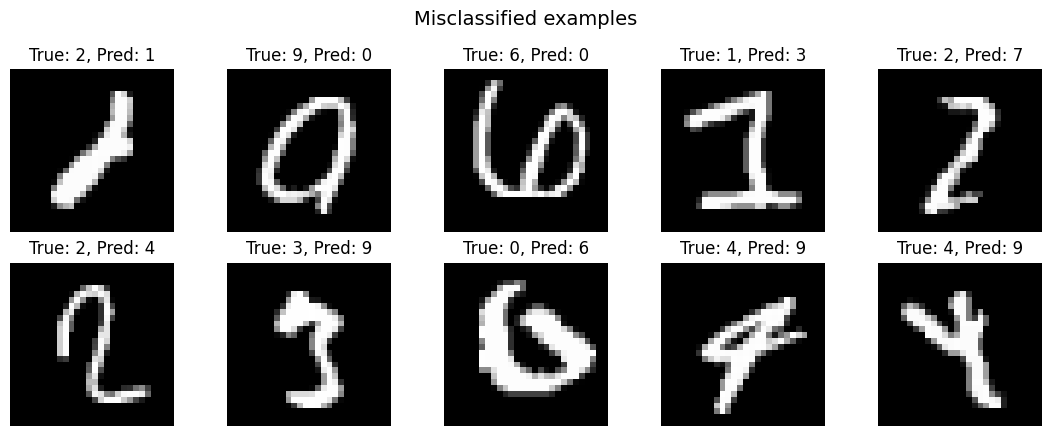

In [ ]:
# Ошибки конкретной модели (Logistic Regression)
show_misclassified_examples(log_reg_model, X_test, y_test, n_examples=10)

#### 2.3 Общие ошибки всех моделей

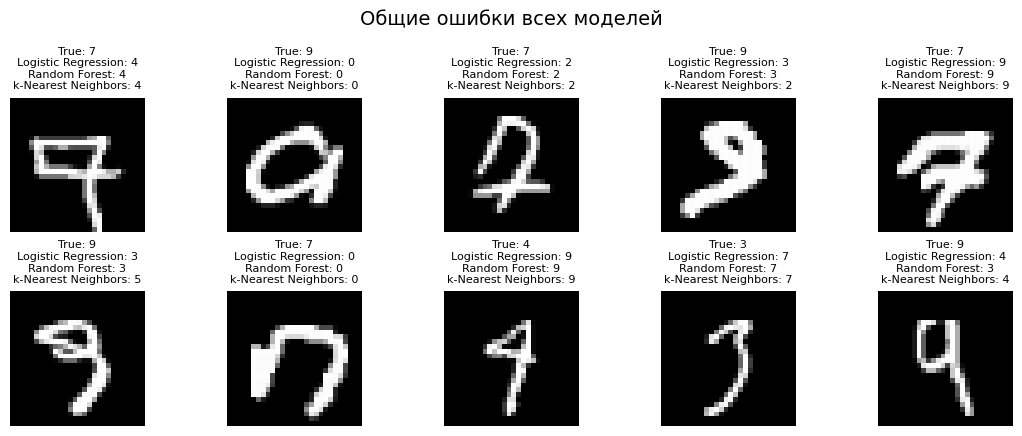

In [24]:
log_reg_pred = log_reg_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
knn_pred = knn_model.predict(X_test)

log_reg_mis = set(np.where(log_reg_pred != y_test)[0])
rf_mis = set(np.where(rf_pred != y_test)[0])
knn_mis = set(np.where(knn_pred != y_test)[0])

# Пересечение ошибок всех трех моделей
common_mis_idx = list(log_reg_mis & rf_mis & knn_mis)

if len(common_mis_idx) == 0:
    print("Нет общих ошибок у всех трех моделей!")
else:
    n_examples = min(10, len(common_mis_idx))
    chosen_idx = random.sample(common_mis_idx, n_examples)

    cols = 5
    rows = int(np.ceil(n_examples / cols))
    plt.figure(figsize=(cols * 2.2, rows * 2.2))
    plt.suptitle("Общие ошибки всех моделей", fontsize=14)

    for i, idx in enumerate(chosen_idx):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        title = (f"True: {y_test[idx]}\n"
                 f"Logistic Regression: {log_reg_pred[idx]}\n"
                 f"Random Forest: {rf_pred[idx]}\n"
                 f"k-Nearest Neighbors: {knn_pred[idx]}")
        plt.title(title, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### 2.4 Важность пикселей согласно PCA

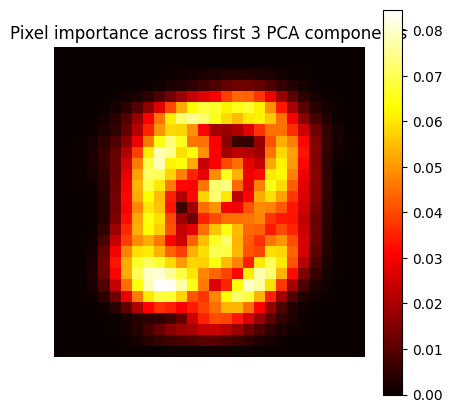

In [ ]:
img_shape = (28,28)
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(X_train)
components = pca.components_[:n_components]
importance = np.mean(np.abs(components), axis=0)

plt.figure(figsize=(5, 5))
plt.imshow(importance.reshape(img_shape), cmap='hot')
plt.title(f"Pixel importance across first {n_components} PCA components")
plt.axis('off')
plt.colorbar()
plt.show()

#### 2.5 Проекция данных на 2D и 3D

In [98]:
X_test_pca = pca.transform(X_test)[:, :3]

fig_3d = px.scatter_3d(
    x=X_test_pca[:, 0],
    y=X_test_pca[:, 1],
    z=X_test_pca[:, 2],
    color=y_test.astype(str),
    labels={'color': 'Цифра'},
    title='3D проекция X_test по первым 3 компонентам PCA',
    opacity=0.2
)
fig_3d.update_traces(marker=dict(size=3), showlegend=False)
fig_3d.update_layout(showlegend=False)

fig_2d = px.scatter(
    x=X_test_pca[:, 0],
    y=X_test_pca[:, 1],
    color=y_test.astype(str),
    labels={'color': 'Цифра', 'x': 'PCA 1', 'y': 'PCA 2'},
    title='2D проекция X_test по первым 2 компонентам PCA',
    opacity=0.7
)
fig_2d.update_traces(marker=dict(size=4))
fig_2d.update_layout(showlegend=True)

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'xy'}]],
    subplot_titles=('3D проекция', '2D проекция')
)

for trace in fig_3d.data:
    fig.add_trace(trace, row=1, col=1)

for trace in sorted(fig_2d.data, key=lambda sct: sct.name):
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(height=500, width=1100)
fig.update_layout(title_text="Проекции X_test по первым компонентам PCA")
fig.show()

**Наблюдение**: в проекции на 3D (и даже 2D) видно, что наиболее отличима цифра `1` (жёлтое облако), как раз именно её модели наиболее успешно узнают (*см. таблицу в п. 2.1*).

## 4. Выводы

| Модель                  | Время обучения                                 | Использование PCA                                          | Точность / качество               | Преимущества                                                                                                        | Недостатки                                                                                                                            | Комментарии                                                                                                                                                                                                                               |
| ----------------------- | ---------------------------------------------- | ---------------------------------------------------------- | --------------------------------- | ------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Logistic Regression** | Быстро                                   | Меньшее количество компонентов (PCA + полиномиальные фичи) | F1 ~ 0.96 (достаточно высокая)    | - Быстрое обучение и предсказание <br> - Хорошо работает при линейной зависимости <br> - Интерпретируемая           | - Ограничена линейными зависимостями <br> - Могут не уловить сложные нелинейные паттерны                                              | Использование PCA с меньшим числом компонентов плюс полиномиальные признаки позволяет добавить нелинейность, что делает модель конкурентоспособной по точности. Отличный выбор, если важна скорость и интерпретируемость.                 |
| **Random Forest**       | Медленно                                       | PCA необязателен (модель и так учитывает нелинейности)     | Высокая, предел выше логрегрессии | - Обрабатывает нелинейные зависимости <br> - Чувствительна к выбросам и шуму <br> - Не требует масштабирования признаков | - Долго обучается <br> - Более сложная интерпретация <br> - Могут быть большие модели                                                 | Random Forest достигает высокой точности без необходимости сложных трансформаций признаков, особенно на больших и сложных данных. Хороший выбор, если важна максимальная точность, а время обучения не критично.                          |
| **KNN**                 | Средне/долго (зависит от числа объектов и фич) | PCA необязателен, но помогает уменьшить размерность        | Высокая, предел выше логрегрессии | - Простая концепция <br> - Хорошо справляется с нелинейными разделениями <br> - Не требует обучения (lazy learning) | - Медленные предсказания на больших данных <br> - Чувствителен к шуму и масштабированию признаков <br> - Требует хранения всех данных | KNN хорошо работает при адекватной размерности (PCA помогает уменьшить размерность), но скорость предсказания может страдать на больших датасетах. Отлично подходит для задач с меньшими объемами данных или для «пробных» экспериментов. |
